# 불법 현수막 탐지 프로젝트 Main

### <시나리오>

* 촬영 데이터 입력
* Yolov8 현수막 추출
* OCR 텍스트 추출
* chatGPT 대분류
* Dataframe에 기록

##### 1) 마을버스/순찰차/순찰 시 GPS 기준 이동거리 5m 간격 촬영

In [129]:
import json

# 촬영된 데이터 format 예시
# 16개의 사진 데이터 
json_file_path = 'capture_data/meta_data.json'

with open(json_file_path, 'r') as json_file:
    meta_data = json.load(json_file)

# 카메라 촬영을 통해 필요한 데이터 요소
# id(고유키), filename(파일명), timestamp(날짜/시간), location(위도/경도)
meta_data

{'dataset_info': {'name': '불법 현수막 탐지 프로젝트 데이터셋',
  'version': '1.0',
  'description': '도로에서 촬영한 불법 현수막 탐지 데이터셋',
  'date_created': '2023-08-12T15:00:00.123456'},
 'data': [{'id': 1,
   'file_name': 'data_001.jpg',
   'timestamp': '2023-08-12T15:00:00.123456',
   'location': {'latitude': 37.123456, 'longitude': -122.789012}},
  {'id': 2,
   'file_name': 'data_002.jpg',
   'timestamp': '2023-08-12T15:05:00.123456',
   'location': {'latitude': 37.123501, 'longitude': -122.789012}},
  {'id': 3,
   'file_name': 'data_003.jpg',
   'timestamp': '2023-08-12T15:10:00.123456',
   'location': {'latitude': 37.123546, 'longitude': -122.789012}},
  {'id': 4,
   'file_name': 'data_004.jpg',
   'timestamp': '2023-08-12T15:15:00.123456',
   'location': {'latitude': 37.123591, 'longitude': -122.789012}},
  {'id': 5,
   'file_name': 'data_005.jpg',
   'timestamp': '2023-08-12T15:20:00.123456',
   'location': {'latitude': 37.123636, 'longitude': -122.789012}},
  {'id': 6,
   'file_name': 'data_006.jpg',
 

##### 2) yolov8 활용 데이터별(id별) 현수막 crop

In [130]:
# 학습한 모델 load

# https://stackoverflow.com/questions/24773109/how-to-downgrade-the-installed-version-of-pip-on-windows
# pip install torchvision==0.15.1
from ultralytics import YOLO
import torch
from datetime import datetime
import shutil
import os
from glob import glob
import time

# cpu
# device = 'cpu'

# gpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

model = YOLO('models/08_13_banner576_best.pt')
model

cuda


In [131]:
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm

# DataFrame 정의

# <Columns>  
# Id(고유 키)
# Date(날짜) 
# Time(시간) 
# Location(위치) 
# Origin_img(원본사진) 
# Crop_imgs(detect된 사진들) 
# OCR_text(추출 텍스트)
# Category(현수막 종류) 
# Legality(합/불법)  


print(" meta data 요소 : ",meta_data['data'][0].keys())

df_data = []
for item in tqdm(meta_data['data']):

    date_time = item['timestamp'].split("T")
    df_row = {
        'ID' : item['id'],
        'Date' : date_time[0],
        'Time' : date_time[1],
        'Location' : [item['location']['latitude'], item['location']['longitude']],
        'Origin_img' : np.array(Image.open('capture_data/'+item['file_name'])),
        'Detect_img' : [],
        'Crop_classes' : [],
        'Crop_imgs' : [],
        'Crop_xyxy' : [], # 좌표 시작점 x,y / 끝점 x,y
        'Crop_conf': [],
        'OCR_text' : [],
        'Category' : [],
        'Legality' : []
    }

    df_data.append(df_row)

df_report = pd.DataFrame(df_data)

# date_created : 데이터 수집한 날짜
date_created = meta_data['dataset_info']['date_created'].split("T")[0].split("-")
df_report.to_csv('reports/report_'+'_'.join(date_created)+'.csv')
df_report

 meta data 요소 :  dict_keys(['id', 'file_name', 'timestamp', 'location'])


100%|██████████| 16/16 [00:00<00:00, 231.16it/s]


,ID,Date,Time,Location,Origin_img,Detect_img,Crop_classes,Crop_imgs,Crop_xyxy,Crop_conf,OCR_text,Category,Legality
0,1,2023-08-12,15:00:00.123456,"[37.123456, -122.789012]","[[[76, 104, 105], [74, 102, 103], [84, 112, 11...",[],[],[],[],[],[],[],[]
1,2,2023-08-12,15:05:00.123456,"[37.123501, -122.789012]","[[[38, 37, 35], [46, 45, 43], [73, 73, 71], [8...",[],[],[],[],[],[],[],[]
2,3,2023-08-12,15:10:00.123456,"[37.123546, -122.789012]","[[[21, 44, 24], [5, 28, 8], [9, 31, 10], [14, ...",[],[],[],[],[],[],[],[]
3,4,2023-08-12,15:15:00.123456,"[37.123591, -122.789012]","[[[60, 102, 127], [101, 143, 168], [111, 153, ...",[],[],[],[],[],[],[],[]
4,5,2023-08-12,15:20:00.123456,"[37.123636, -122.789012]","[[[175, 205, 205], [169, 191, 188], [79, 92, 8...",[],[],[],[],[],[],[],[]
5,6,2023-08-12,15:25:00.123456,"[37.123681, -122.789012]","[[[95, 107, 93], [101, 111, 100], [108, 118, 1...",[],[],[],[],[],[],[],[]
6,7,2023-08-12,15:30:00.123456,"[37.123726, -122.789012]","[[[113, 113, 105], [97, 97, 89], [86, 86, 78],...",[],[],[],[],[],[],[],[]
7,8,2023-08-12,15:35:00.123456,"[37.123771, -122.789012]","[[[26, 31, 37], [28, 33, 39], [32, 37, 41], [4...",[],[],[],[],[],[],[],[]
8,9,2023-08-12,15:40:00.123456,"[37.123816, -122.789012]","[[[251, 248, 243], [249, 248, 243], [248, 251,...",[],[],[],[],[],[],[],[]
9,10,2023-08-12,15:45:00.123456,"[37.123861, -122.789012]","[[[123, 159, 89], [109, 144, 80], [175, 208, 1...",[],[],[],[],[],[],[],[]


In [64]:
class_names = ['banner','frame']
image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.gif']

predict_path = 'runs/detect/predict/'
predict_detect_path = predict_path
predict_crop_banner_path = predict_path+class_names[0]
predict_crop_frame_path = predict_path+class_names[1]

log_path = 'logs/'

In [65]:
def move_all_img(source_folder, destination_folder):
    # source_folder 내의 모든 항목을 destination_folder로 이동
    for item in os.listdir(source_folder):
        source_item = os.path.join(source_folder, item)
        destination_item = os.path.join(destination_folder, item)
        shutil.move(source_item, destination_item)

In [66]:
def move_img(source_path, destination_path):
    if not os.path.exists(os.path.dirname('/'.join(destination_path.split('/')[:-1])+'/')):
        os.makedirs(os.path.dirname('/'.join(destination_path.split('/')[:-1])+'/'))
    
    # 파일 이동
    shutil.move(source_path, destination_path)

In [122]:
def yolo_run(img):

    # GPU predict 시, show=False/save=True로 설정 
    results = model.predict(
                            source=img, # 디렉토리 (capture_data/)
                            conf=0.5, # confidence threshold for detection (오탐지 시 재설정)
                            save=True,  # Detect 결과 저장 (runs/detect/predict)
                            device=device, # device 설정
                            show=False, # window 창으로 show
                            save_crop=True # Detect된 Obeject 사진 저장 (runs/detect/predict/crops)
                            )
    
    image = np.array(Image.open(img))
    # print("image : ",image)
    print("image.shape : ",image.shape)

    for idx,result in enumerate(results):
        now = datetime.now()
        now_time = str(now.year) + str(now.month) + str(now.day) + '_' + str(now.hour) + str(now.minute) + str(now.second)

        boxes = result.boxes
        saved_img = ''

        print("================================= Predict 결과 =================================")

        file_name = img.split('\\')[-1]
        img_name = file_name[:-4]
        # ext_name = file_name[-4:]

        ### 데이터 logs에 저장
        # 데이터이름+날짜시간
        data_datetime_dir = log_path+now_time+'_'+img_name+'/'
        # predict된 결과를 'logs/'에 저장
        move_all_img(predict_path,data_datetime_dir)
        # 원본 이미지 저장
        os.makedirs(data_datetime_dir+'origin_img/')
        shutil.copyfile(img,data_datetime_dir+'origin_img/'+img.split('\\')[-1])
        # detect된 이미지 저장
        move_img(data_datetime_dir+file_name,data_datetime_dir+'detect_img/'+file_name)
        # crop_imgs로 폴더명 변경
        os.rename(data_datetime_dir+'crops', data_datetime_dir+'crop_imgs')

        ### 데이터 df에 저장
        # ID 값
        id = int(img_name.split('_')[-1])-1
        # detect_img 기록
        df_report['Detect_img'].iloc[id] = np.array(Image.open(data_datetime_dir+'detect_img/'+file_name))

        crop_classes = []
        crop_imgs = []
        crop_xyxy = []
        crop_conf = []
        for idx,box in enumerate(boxes):
            # crop된 object 이름 기록
            crop_classes.append(class_names[int(box.cls)])
            # xyxy : x_min,y_min,x_max,y_max
            xyxy = box.xyxy[0].to('cpu').numpy().astype('uint8')
            xyxy = list(box.xyxy[0].to('cpu').numpy().astype('uint8'))
            print(" start X, start Y, end X, end Y, ", xyxy)
            print("type: ",type(xyxy))
            x_min, y_min, x_max, y_max = xyxy
            print("x_min, y_min, x_max, y_max : ",x_min, y_min, x_max, y_max)
            crop_imgs.append(image[y_min:y_max, x_min:x_max])
            crop_xyxy.append([x_min, y_min, x_max, y_max])
            crop_conf.append(box.conf.detach().cpu().numpy())

            print()
            # print(" "+str(idx+1) + "번째 결과")
            print(" Detect 클래스 : ", class_names[int(box.cls)])
            print(" confidence 확률 : ", box.conf)
            print(" 중심x, 중심y, 너비, 높이 : ", box.xywh)
            # xyxy : x_min,y_min,x_max,y_max
            print(" start X, start Y, end X, end Y, ", box.xyxy)
            print()
            print("================================================================================")
            
        # crop된 object 이름 기록
        df_report['Crop_classes'].iloc[id] = crop_classes
        df_report['Crop_imgs'].iloc[id] = crop_imgs
        df_report['Crop_xyxy'].iloc[id] = crop_xyxy
        df_report['Crop_conf'].iloc[id] = crop_conf

In [126]:
def ocr_run():
    print("OCR 프로세스...")

In [127]:
def chatGPT_run():
    print("chatGPT 프로세스...")

#### 모듈 실행

In [123]:
# imgs = 이미지 데이터 경로

imgs = glob('capture_data/*.jpg')

for img in imgs:
    yolo_run(img)
    # break
    ocr_run()
    chatGPT_run()

df_report.to_csv('reports/report_'+'_'.join(date_created)+'.csv')


image 1/1 c:\backend_study\META_August_PJT\ljm\capture_data\data_001.jpg: 384x640 3 banners, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs\detect\predict


image.shape :  (383, 680, 3)
================================= Predict 결과 =================================
 start X, start Y, end X, end Y,  [109, 23, 40, 164]
type:  <class 'list'>
x_min, y_min, x_max, y_max :  109 23 40 164

 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.6982], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[458.5684,  93.7201, 186.9148, 140.7925]], device='cuda:0')
 start X, start Y, end X, end Y,  tensor([[365.1110,  23.3238, 552.0258, 164.1163]], device='cuda:0')

 start X, start Y, end X, end Y,  [111, 42, 248, 99]
type:  <class 'list'>
x_min, y_min, x_max, y_max :  111 42 248 99

 Detect 클래스 :  banner
 confidence 확률 :  tensor([0.6470], device='cuda:0')
 중심x, 중심y, 너비, 높이 :  tensor([[308.0838, 198.8755, 393.7336, 313.2115]], device='cuda:0')
 start X, start Y, end X, end Y,  tensor([[111.2169,  42.2698, 504.9506, 355.4813]], device='cuda:0')

 start X, start Y, end X, end Y,  [122, 182, 248, 89]
type:  <class 'list'>
x_min, y_min, x_max, y_max :  122 182 248 89

C:\Users\user\AppData\Local\Temp\ipykernel_8008\53095795.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report['Detect_img'].iloc[id] = np.array(Image.open(data_datetime_dir+'detect_img/'+file_name))
C:\Users\user\AppData\Local\Temp\ipykernel_8008\53095795.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_report['Crop_classes'].iloc[id] = crop_classes
C:\Users\user\AppData\Local\Temp\ipykernel_8008\53095795.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [124]:
df_report

,ID,Date,Time,Location,Origin_img,Detect_img,Crop_classes,Crop_imgs,Crop_xyxy,Crop_conf,OCR_text,Category,Legality
0,1,2023-08-12,15:00:00.123456,"[37.123456, -122.789012]","[[[76, 104, 105], [74, 102, 103], [84, 112, 11...","[[[78, 104, 105], [76, 102, 103], [86, 112, 11...","[banner, banner, banner]","[[[], [], [], [], [], [], [], [], [], [], [], ...","[[109, 23, 40, 164], [111, 42, 248, 99], [122,...","[[0.6982214], [0.64700276], [0.6176365]]",[],[],[]
1,2,2023-08-12,15:05:00.123456,"[37.123501, -122.789012]","[[[38, 37, 35], [46, 45, 43], [73, 73, 71], [8...",[],[],[],[],[],[],[],[]
2,3,2023-08-12,15:10:00.123456,"[37.123546, -122.789012]","[[[21, 44, 24], [5, 28, 8], [9, 31, 10], [14, ...",[],[],[],[],[],[],[],[]
3,4,2023-08-12,15:15:00.123456,"[37.123591, -122.789012]","[[[60, 102, 127], [101, 143, 168], [111, 153, ...",[],[],[],[],[],[],[],[]
4,5,2023-08-12,15:20:00.123456,"[37.123636, -122.789012]","[[[175, 205, 205], [169, 191, 188], [79, 92, 8...",[],[],[],[],[],[],[],[]
5,6,2023-08-12,15:25:00.123456,"[37.123681, -122.789012]","[[[95, 107, 93], [101, 111, 100], [108, 118, 1...",[],[],[],[],[],[],[],[]
6,7,2023-08-12,15:30:00.123456,"[37.123726, -122.789012]","[[[113, 113, 105], [97, 97, 89], [86, 86, 78],...",[],[],[],[],[],[],[],[]
7,8,2023-08-12,15:35:00.123456,"[37.123771, -122.789012]","[[[26, 31, 37], [28, 33, 39], [32, 37, 41], [4...",[],[],[],[],[],[],[],[]
8,9,2023-08-12,15:40:00.123456,"[37.123816, -122.789012]","[[[251, 248, 243], [249, 248, 243], [248, 251,...",[],[],[],[],[],[],[],[]
9,10,2023-08-12,15:45:00.123456,"[37.123861, -122.789012]","[[[123, 159, 89], [109, 144, 80], [175, 208, 1...",[],[],[],[],[],[],[],[]


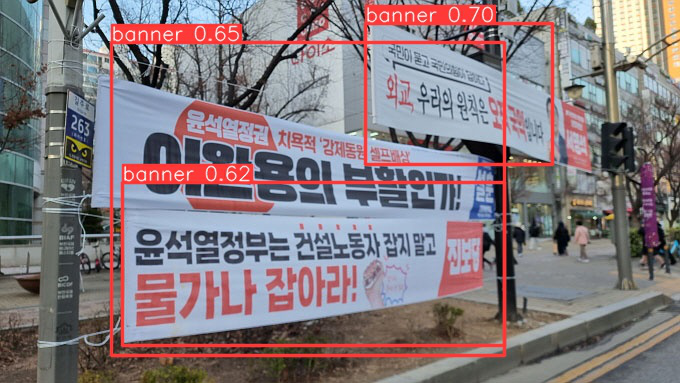

In [50]:
import pandas as pd
from PIL import Image

# df_report = pd.read_csv('reports/report_2023_08_12.csv',encoding='cp949')

img = Image.fromarray(np.uint8(df_report.loc[0]['Detect_img']))
display(img)

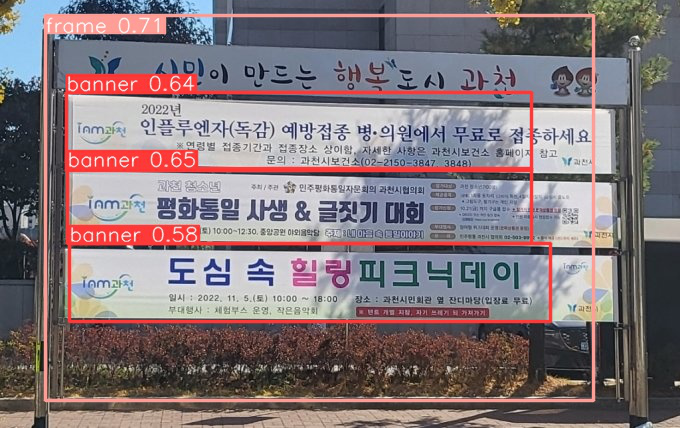

In [51]:
img = Image.fromarray(np.uint8(df_report.loc[1]['Detect_img']))
display(img)

##### 로그 저장 디렉토리

In [12]:
# !pip install tree
# 원본 이미지(origin_img), detect된 이미지(detect_img), crop된 이미지(crop_imgs,'banner','frame')

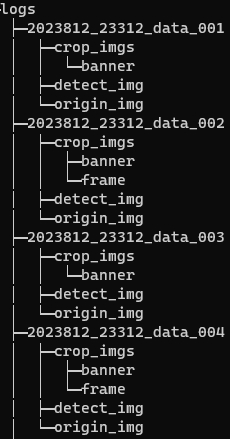